In [ ]:
# !pip install catboost
# !pip install --upgrade xgboost


# Import the library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import DMatrix
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
from scipy.stats import ttest_ind,chi2_contingency
from sklearn.model_selection import train_test_split
import gc

# READING THE TRAIN AND TEST FILE PATH

In [ ]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

# TRAIN AND TEST DATASET SAMPLE

In [ ]:
df_train.sample(5).style.background_gradient()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
84277,84277,F,0.580000,0.450000,0.170000,1.096500,0.419000,0.264000,0.410000,13
63917,63917,I,0.470000,0.355000,0.120000,0.580500,0.282500,0.093500,0.184000,8
66989,66989,I,0.400000,0.305000,0.090000,0.280000,0.150500,0.064500,0.076500,8
17502,17502,I,0.550000,0.430000,0.140000,0.836000,0.372500,0.181500,0.220000,9
81541,81541,M,0.585000,0.465000,0.165000,1.087500,0.455500,0.261500,0.315000,18


In [ ]:
df_test.sample(5).style.background_gradient()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
48365,138980,M,0.585000,0.450000,0.160000,0.979500,0.450000,0.168500,0.295000
29736,120351,I,0.440000,0.350000,0.100000,0.365000,0.165500,0.083000,0.104500
3269,93884,F,0.630000,0.475000,0.165000,1.170500,0.548500,0.270500,0.280000
23895,114510,M,0.500000,0.380000,0.115000,0.578000,0.259500,0.130500,0.160000
3880,94495,F,0.595000,0.465000,0.165000,1.092500,0.426500,0.237500,0.251500


# INFORMATION ABOUT TRAIN AND TEST DATA

In [ ]:
df_train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60411 entries, 0 to 60410
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              60411 non-null  int64  
 1   Sex             60411 non-null  object 
 2   Length          60411 non-null  float64
 3   Diameter        60411 non-null  float64
 4   Height          60411 non-null  float64
 5   Whole weight    60411 non-null  float64
 6   Whole weight.1  60411 non-null  float64
 7   Whole weight.2  60411 non-null  float64
 8   Shell weight    60411 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.1+ MB


# STATICAL INFORMATION ABOUT TRAIN AND TEST DATA

In [ ]:
df_train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,90615.000000,45307.000000,26158.441658,0.000000,22653.500000,45307.000000,67960.500000,90614.000000
Length,90615.000000,0.517098,0.118217,0.075000,0.445000,0.545000,0.600000,0.815000
Diameter,90615.000000,0.401679,0.098026,0.055000,0.345000,0.425000,0.470000,0.650000
Height,90615.000000,0.135464,0.038008,0.000000,0.110000,0.140000,0.160000,1.130000
Whole weight,90615.000000,0.789035,0.457671,0.002000,0.419000,0.799500,1.067500,2.825500
Whole weight.1,90615.000000,0.340778,0.204428,0.001000,0.177500,0.330000,0.463000,1.488000
Whole weight.2,90615.000000,0.169422,0.100909,0.000500,0.086500,0.166000,0.232500,0.760000
Shell weight,90615.000000,0.225898,0.130203,0.001500,0.120000,0.225000,0.305000,1.005000
Rings,90615.000000,9.696794,3.176221,1.000000,8.000000,9.000000,11.000000,29.000000


In [ ]:
df_test.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
id,60411.000000,120820.000000,17439.297893,90615.000000,105717.500000,120820.000000,135922.500000,151025.000000
Length,60411.000000,0.517428,0.117609,0.075000,0.450000,0.545000,0.600000,0.800000
Diameter,60411.000000,0.401961,0.097470,0.055000,0.345000,0.425000,0.470000,0.650000
Height,60411.000000,0.135751,0.038175,0.000000,0.110000,0.140000,0.160000,1.095000
Whole weight,60411.000000,0.790062,0.457591,0.002000,0.419500,0.801500,1.070000,2.825500
Whole weight.1,60411.000000,0.341227,0.204221,0.001000,0.178500,0.329000,0.464500,1.488000
Whole weight.2,60411.000000,0.169419,0.100720,0.000500,0.086500,0.166000,0.232500,0.641500
Shell weight,60411.000000,0.226125,0.129826,0.001500,0.120000,0.225000,0.305000,1.004000


# NULL VALUE CHECK IN TRAIN AND TEST DATA

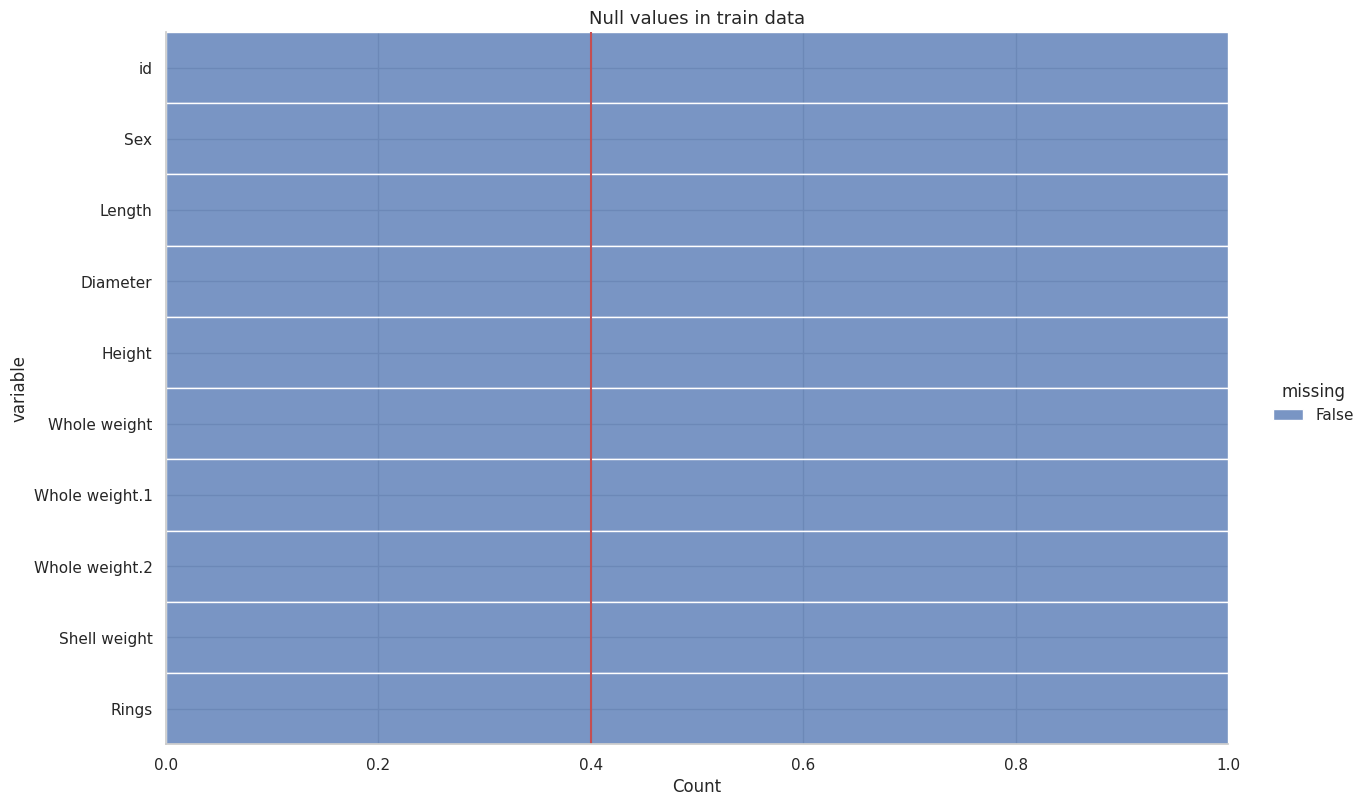

In [ ]:
sns.displot(data=df_train.isnull().melt(value_name = 'missing'),
           y = 'variable',
           hue = 'missing',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Null values in train data",fontsize = 13)
plt.show()

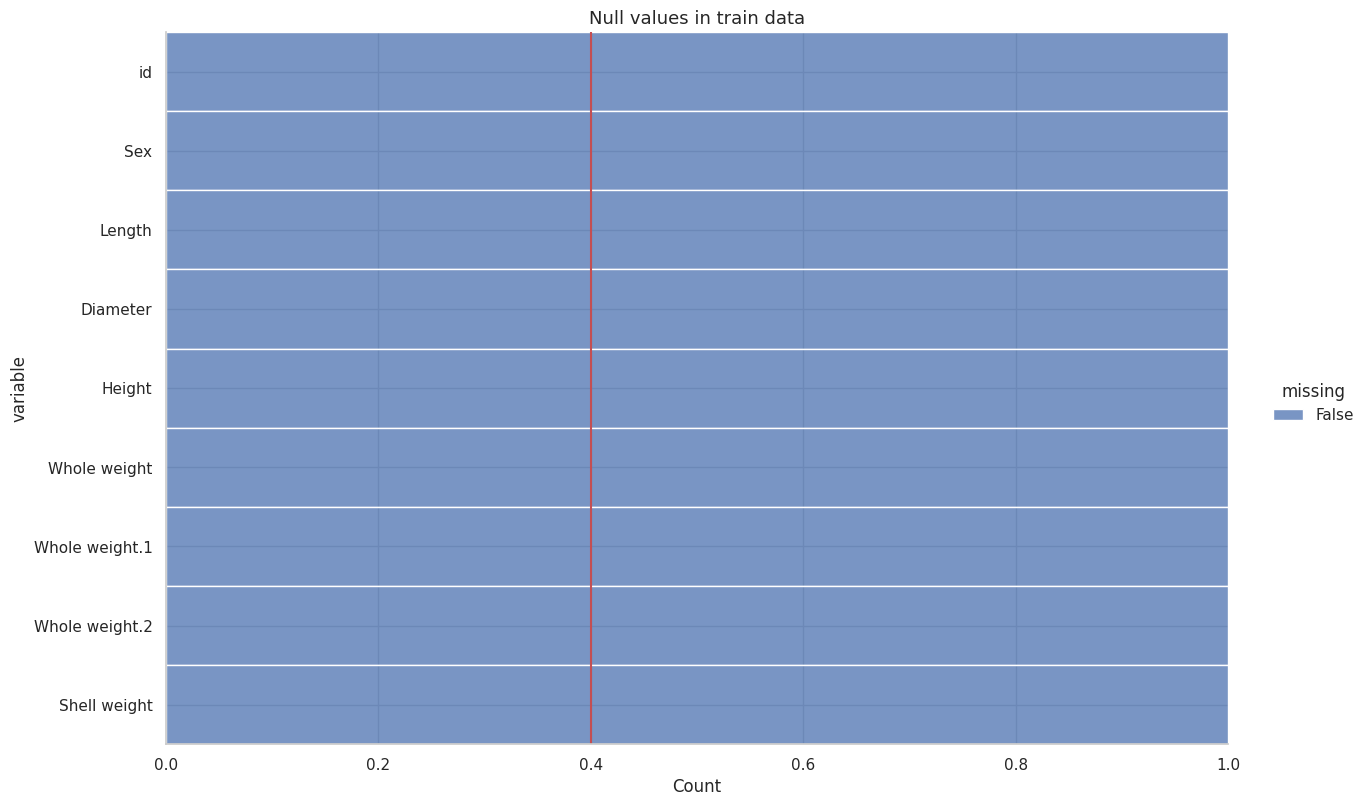

In [ ]:
sns.displot(data=df_test.isnull().melt(value_name = 'missing'),
           y = 'variable',
           hue = 'missing',multiple='fill',height=8,aspect = 1.6)
plt.axvline(0.4,color = 'r')
plt.title("Null values in train data",fontsize = 13)
plt.show()

# CATEGORICAL COLUMN ANALYSIS🎇

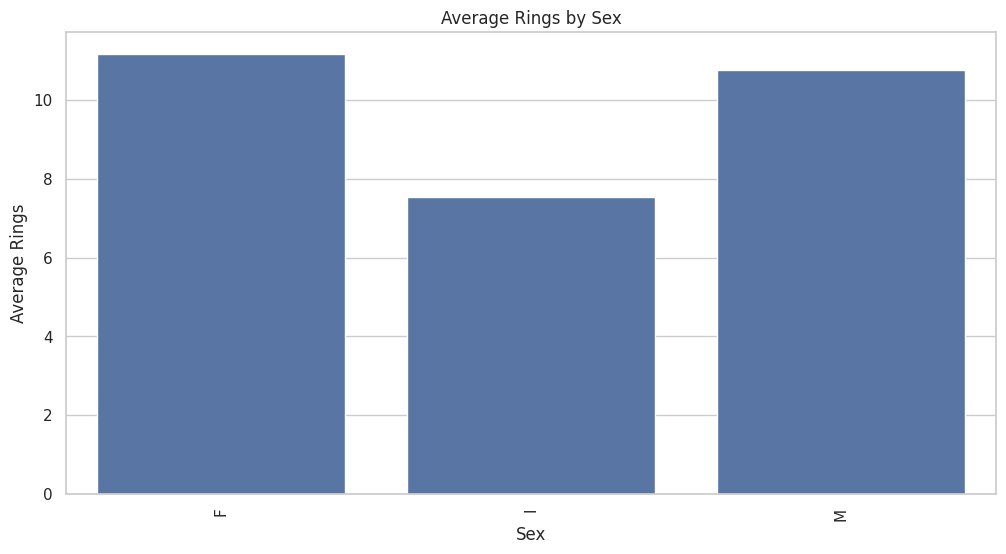

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Sex', y='Rings', data=df_train, errorbar=None)
plt.title('Average Rings by Sex')
plt.xlabel('Sex')
plt.ylabel('Average Rings')
plt.xticks(rotation=90)
plt.show()

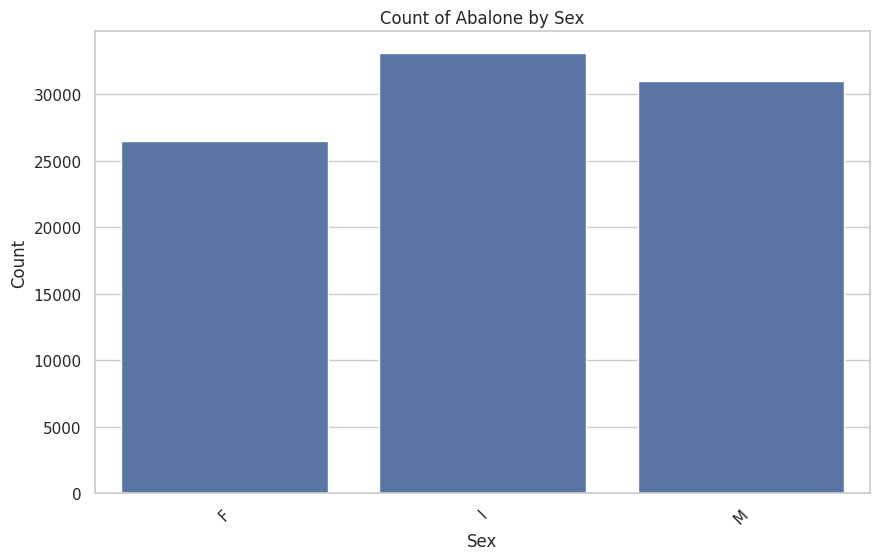

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', data=df_train)
plt.title('Count of Abalone by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 🔍FEATURE ENGENEERING🔍

In [ ]:
df_train.columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [ ]:
df_train['Diameter_to_Height_Ratio'] = df_train['Diameter'] / df_train['Height']
df_train['Combined_Whole_Weight'] = df_train['Whole weight'] + df_train['Whole weight.1'] + df_train['Whole weight.2']
df_train['Diameter_Length_Product'] = df_train['Diameter'] * df_train['Length']
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
df_train['Sex'] = df_train['Sex'].map(sex_mapping)
df_train['Shell_Volume'] = (4/3) * 3.14 * (df_train['Diameter'] / 2)**2 * df_train['Height']
df_train['Shell_Surface_Area'] = 4 * 3.14 * (df_train['Diameter'] / 2)**2
df_train['Shell_Density'] = df_train['Shell weight'] / df_train['Shell_Volume']
df_train['Shell_Thickness'] = df_train['Height'] - df_train['Diameter']
df_train['Shell_Shape_Index'] = df_train['Shell_Surface_Area'] / df_train['Shell_Volume']
df_train['Length_to_Height_Ratio'] = df_train['Length'] / df_train['Height']

In [ ]:
df_test['Diameter_to_Height_Ratio'] = df_test['Diameter'] / df_test['Height']
df_test['Combined_Whole_Weight'] = df_test['Whole weight'] + df_test['Whole weight.1'] + df_test['Whole weight.2']
df_test['Diameter_Length_Product'] = df_test['Diameter'] * df_test['Length']
sex_mapping = {'M': 0, 'F': 1, 'I': 2}
df_test['Sex'] = df_test['Sex'].map(sex_mapping)
df_test['Shell_Volume'] = (4/3) * 3.14 * (df_test['Diameter'] / 2)**2 * df_test['Height']
df_test['Shell_Surface_Area'] = 4 * 3.14 * (df_test['Diameter'] / 2)**2
df_test['Shell_Density'] = df_test['Shell weight'] / df_test['Shell_Volume']
df_test['Shell_Thickness'] = df_test['Height'] - df_test['Diameter']
df_test['Shell_Shape_Index'] = df_test['Shell_Surface_Area'] / df_test['Shell_Volume']
df_test['Length_to_Height_Ratio'] = df_test['Length'] / df_test['Height']

In [ ]:
df_train.sample(5).style.background_gradient()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Diameter_to_Height_Ratio,Combined_Whole_Weight,Diameter_Length_Product,Shell_Volume,Shell_Surface_Area,Shell_Density,Shell_Thickness,Shell_Shape_Index,Length_to_Height_Ratio
72737,72737,2,0.405000,0.310000,0.095000,0.369000,0.181000,0.085000,0.093000,8,3.263158,0.635000,0.125550,0.009556,0.301754,9.732571,-0.215000,31.578947,4.263158
35411,35411,0,0.645000,0.515000,0.170000,1.460500,0.660500,0.310500,0.364500,13,3.029412,2.431500,0.332175,0.047192,0.832807,7.723706,-0.345000,17.647059,3.794118
17590,17590,1,0.610000,0.495000,0.170000,1.289500,0.530500,0.288500,0.355000,12,2.911765,2.108500,0.301950,0.043598,0.769378,8.142554,-0.325000,17.647059,3.588235
50049,50049,2,0.285000,0.225000,0.080000,0.173500,0.060000,0.033000,0.050000,6,2.812500,0.266500,0.064125,0.004239,0.158963,11.795235,-0.145000,37.500000,3.562500
71157,71157,2,0.430000,0.310000,0.095000,0.391500,0.178500,0.074500,0.088000,7,3.263158,0.644500,0.133300,0.009556,0.301754,9.209314,-0.215000,31.578947,4.526316


In [ ]:
df_test.sample(5).style.background_gradient()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Diameter_to_Height_Ratio,Combined_Whole_Weight,Diameter_Length_Product,Shell_Volume,Shell_Surface_Area,Shell_Density,Shell_Thickness,Shell_Shape_Index,Length_to_Height_Ratio
51607,142222,2,0.485000,0.375000,0.105000,0.508500,0.210000,0.104000,0.151500,3.571429,0.822500,0.181875,0.015455,0.441563,9.802851,-0.270000,28.571429,4.619048
57990,148605,2,0.415000,0.310000,0.115000,0.336500,0.162500,0.062000,0.104000,2.695652,0.561000,0.128650,0.011567,0.301754,8.990911,-0.195000,26.086957,3.608696
27883,118498,0,0.520000,0.390000,0.125000,0.559500,0.273500,0.144500,0.165000,3.120000,0.977500,0.202800,0.019900,0.477594,8.291561,-0.265000,24.000000,4.160000
19458,110073,1,0.600000,0.505000,0.190000,1.098000,0.435500,0.273500,0.335000,2.657895,1.807000,0.303000,0.050716,0.800779,6.605414,-0.315000,15.789474,3.157895
22879,113494,2,0.400000,0.305000,0.065000,0.273500,0.108000,0.048500,0.072500,4.692308,0.430000,0.122000,0.006329,0.292098,11.455567,-0.240000,46.153846,6.153846


In [ ]:
unique_counts = df_train.nunique()
#Threshold to distinguish continous and categorical
threshold = 12
continuous_vars_temp = unique_counts[unique_counts > threshold].index.tolist()
#categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()
if 'id' in continuous_vars_temp:
    continuous_vars_temp.remove('id')

In [ ]:
numerical_columns = df_train.select_dtypes(include='number').columns

In [ ]:
numerical_columns

Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
       'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings',
       'Diameter_to_Height_Ratio', 'Combined_Whole_Weight',
       'Diameter_Length_Product', 'Shell_Volume', 'Shell_Surface_Area',
       'Shell_Density', 'Shell_Thickness', 'Shell_Shape_Index',
       'Length_to_Height_Ratio'],
      dtype='object')

# 🎇REMOVING THE OUTLIERS🎇

In [ ]:
def remove_outliers_replace(data, columns, threshold=1.5):
    data_no_outliers = data.copy()

    for column in columns:
        Q1 = data_no_outliers[column].quantile(0.25)
        Q3 = data_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        is_outlier = (data_no_outliers[column] < lower_bound) | (data_no_outliers[column] > upper_bound)

        if data_no_outliers[column].dtype == 'O':  # Categorical column
            median_value = data_no_outliers.loc[~is_outlier, column].mode().iloc[0]
            data_no_outliers.loc[is_outlier, column] = median_value
        else:  # Numerical column
            mean_value = data_no_outliers.loc[~is_outlier, column].mean()
            data_no_outliers.loc[is_outlier, column] = mean_value

    return data_no_outliers

columns_to_remove_outliers_replace = continuous_vars_temp
df_train = remove_outliers_replace(df_train, columns_to_remove_outliers_replace)

<ipython-input-639-faf07c56ce88>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.206054894569442' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_no_outliers.loc[is_outlier, column] = mean_value


In [ ]:
columns_to_remove_outliers_replace

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings',
 'Diameter_to_Height_Ratio',
 'Combined_Whole_Weight',
 'Diameter_Length_Product',
 'Shell_Volume',
 'Shell_Surface_Area',
 'Shell_Density',
 'Shell_Thickness',
 'Shell_Shape_Index',
 'Length_to_Height_Ratio']

In [ ]:
columns_to_remove_outliers_replace_test = ['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Diameter_to_Height_Ratio',
 'Combined_Whole_Weight',
 'Diameter_Length_Product','Shell_Volume',
 'Shell_Surface_Area',
 'Shell_Density',
 'Shell_Thickness',
 'Shell_Shape_Index',
 'Length_to_Height_Ratio']
df_test = remove_outliers_replace(df_test, columns_to_remove_outliers_replace_test)

In [ ]:
df_train

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Diameter_to_Height_Ratio,Combined_Whole_Weight,Diameter_Length_Product,Shell_Volume,Shell_Surface_Area,Shell_Density,Shell_Thickness,Shell_Shape_Index,Length_to_Height_Ratio
0,0,1,0.550000,0.43000,0.150000,0.7715,0.3285,0.1465,0.2400,11.0,2.866667,1.2465,0.236500,0.029029,0.580586,8.267509,-0.280000,20.000000,3.666667
1,1,1,0.630000,0.49000,0.145000,1.1300,0.4580,0.2765,0.3200,11.0,3.379310,1.8645,0.308700,0.036439,0.753914,8.781757,-0.345000,20.689655,4.344828
2,2,2,0.522593,0.40645,0.135708,0.0210,0.0055,0.0030,0.0050,6.0,2.996053,0.0295,0.017600,0.000317,0.037994,8.676189,-0.268986,22.732078,3.873581
3,3,0,0.595000,0.47500,0.150000,0.9145,0.3755,0.2055,0.2500,10.0,3.166667,1.4955,0.282625,0.035423,0.708462,7.057537,-0.325000,20.000000,3.966667
4,4,2,0.555000,0.42500,0.130000,0.7820,0.3695,0.1600,0.1975,9.0,3.269231,1.3115,0.235875,0.024577,0.567163,8.035955,-0.295000,23.076923,4.269231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90610,90610,0,0.335000,0.23500,0.075000,0.1585,0.0685,0.0370,0.0450,6.0,3.133333,0.2640,0.078725,0.004335,0.173406,10.380234,-0.160000,40.000000,4.466667
90611,90611,0,0.555000,0.42500,0.150000,0.8790,0.3865,0.1815,0.2400,9.0,2.833333,1.4470,0.235875,0.028358,0.567163,8.463183,-0.275000,20.000000,3.700000
90612,90612,2,0.435000,0.33000,0.095000,0.3215,0.1510,0.0785,0.0815,6.0,3.473684,0.5510,0.143550,0.010828,0.341946,7.526581,-0.235000,31.578947,4.578947
90613,90613,2,0.345000,0.27000,0.075000,0.2000,0.0980,0.0490,0.0700,6.0,3.600000,0.3470,0.093150,0.005723,0.228906,8.676189,-0.195000,40.000000,4.600000


In [ ]:
df_test

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Diameter_to_Height_Ratio,Combined_Whole_Weight,Diameter_Length_Product,Shell_Volume,Shell_Surface_Area,Shell_Density,Shell_Thickness,Shell_Shape_Index,Length_to_Height_Ratio
0,90615,0,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005,3.064516,2.1690,0.306375,0.036604,0.708462,8.209509,-0.320,19.354839,4.161290
1,90616,0,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750,2.875000,1.6810,0.266800,0.035436,0.664424,7.760481,-0.300,18.750000,3.625000
2,90617,0,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405,3.000000,1.3765,0.235200,0.025848,0.553896,9.304222,-0.280,21.428571,4.000000
3,90618,0,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350,3.379310,1.4130,0.279300,0.036439,0.753914,6.449103,-0.345,20.689655,3.931034
4,90619,2,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050,2.954545,0.5825,0.134875,0.012161,0.331663,8.634188,-0.215,27.272727,3.772727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60406,151021,2,0.345,0.260,0.085,0.1775,0.0735,0.0265,0.0500,3.058824,0.2775,0.089700,0.006014,0.212264,8.313731,-0.175,35.294118,4.058824
60407,151022,1,0.525,0.410,0.145,0.8445,0.3885,0.1670,0.2050,2.827586,1.4000,0.215250,0.025512,0.527834,8.035442,-0.265,20.689655,3.620690
60408,151023,2,0.590,0.440,0.155,1.1220,0.3930,0.2000,0.2650,2.838710,1.7150,0.259600,0.031408,0.607904,8.437241,-0.285,19.354839,3.806452
60409,151024,1,0.660,0.525,0.190,1.4935,0.5885,0.3575,0.4350,2.763158,2.4395,0.346500,0.054813,0.865463,7.936128,-0.335,15.789474,3.473684


# Drop id and rings

In [ ]:
df_train.drop(columns='id',axis = 1,inplace = True)

In [ ]:
df_test.drop(columns='id',axis = 1,inplace = True)

In [ ]:
X = df_train.drop(columns='Rings', axis=1)
y = df_train['Rings']

# 🤝CORRELATION🤝

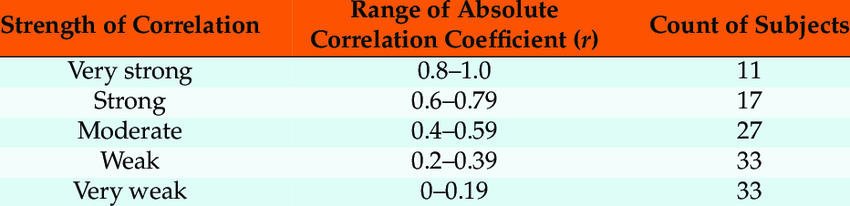

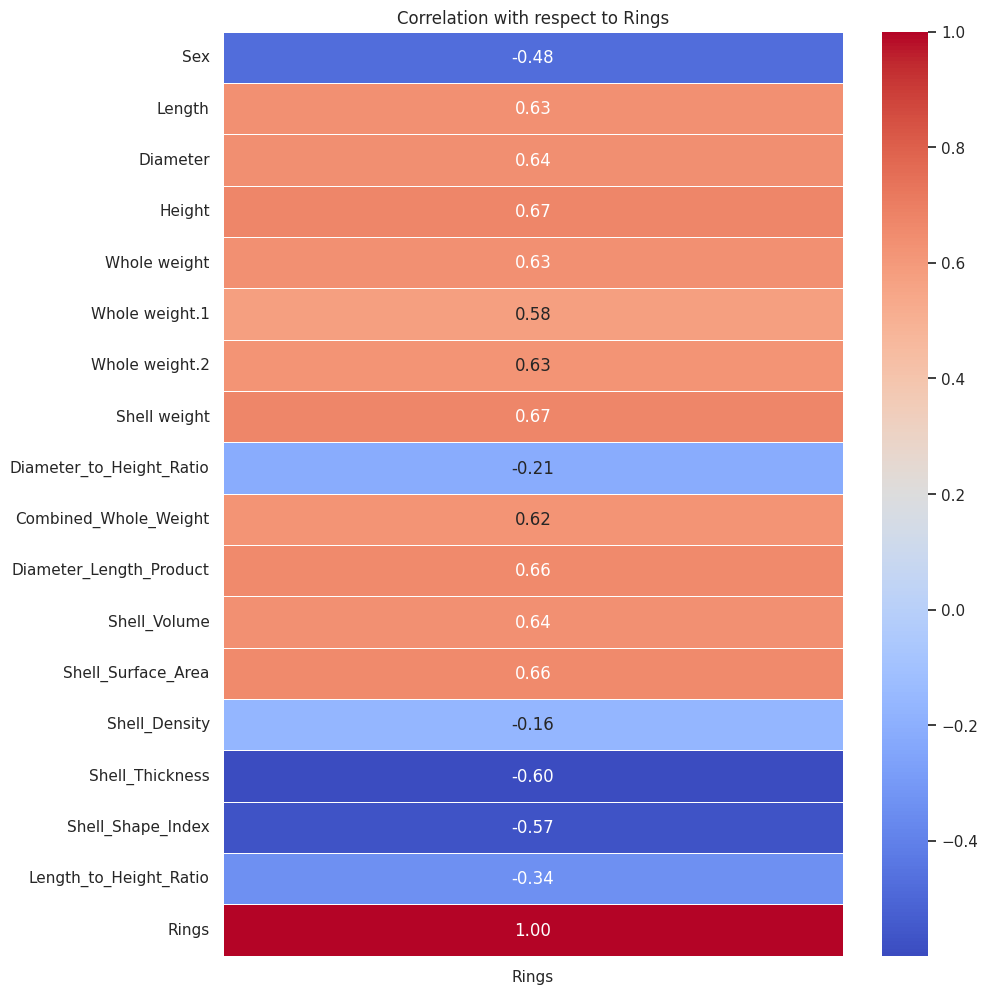

In [ ]:
merged_data = pd.concat([X, y.rename('Rings')], axis=1)

# Calculate the correlation matrix
correlation_matrix = merged_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix[['Rings']], annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation with respect to Rings')
plt.show()

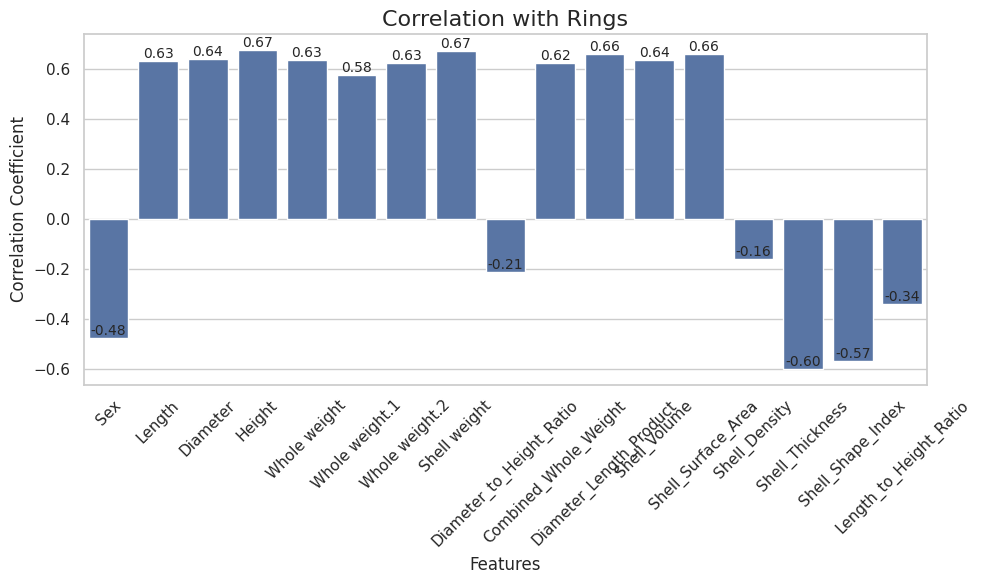

In [ ]:
correlation_matrix = df_train.corr()

correlation_with_price = correlation_matrix['Rings'].drop('Rings')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom',
                     fontsize=10)

plt.title('Correlation with Rings', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

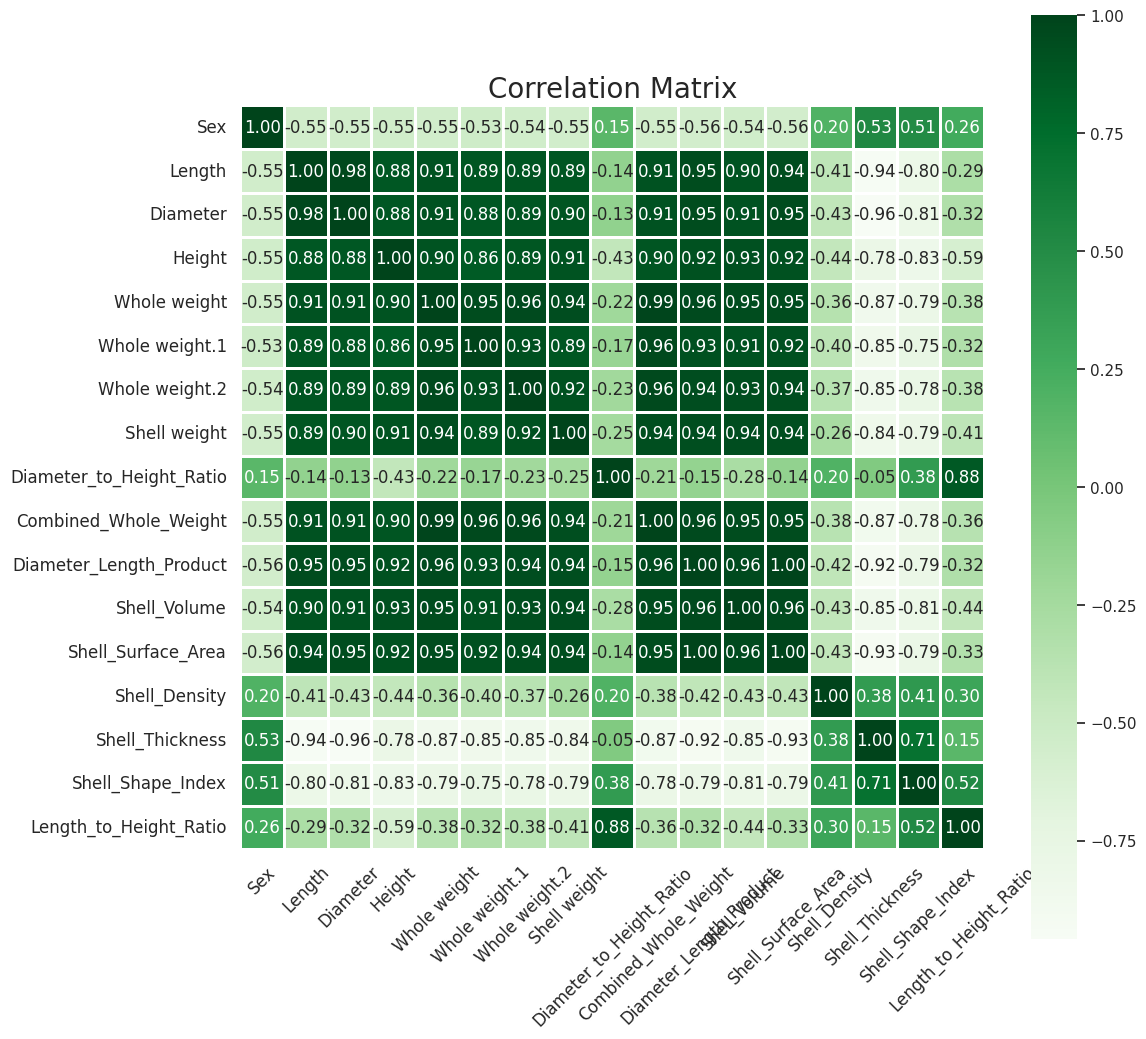

In [ ]:
correlation_matrix = X.corr()

# Set up the matplotlib figure with a larger size
plt.figure(figsize=(12, 12))  # Increase the width and height as needed

# Plot the correlation matrix as a heatmap with larger boxes
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f", linewidths=1, square=True)

# Customize plot
plt.title('Correlation Matrix', fontsize=20)  # Increase the font size of the title
plt.xticks(fontsize=12)  # Increase the font size of x-axis labels
plt.yticks(fontsize=12)  # Increase the font size of y-axis labels

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust the aspect ratio to prevent distortion of cell shapes
heatmap.set_aspect('equal')

plt.show()

# ✨VARIANCE INFLUENCE FACTOR✨

<ipython-input-650-241763d53ed4>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x="VIF", y="Variable", data=vif_data, palette="viridis")


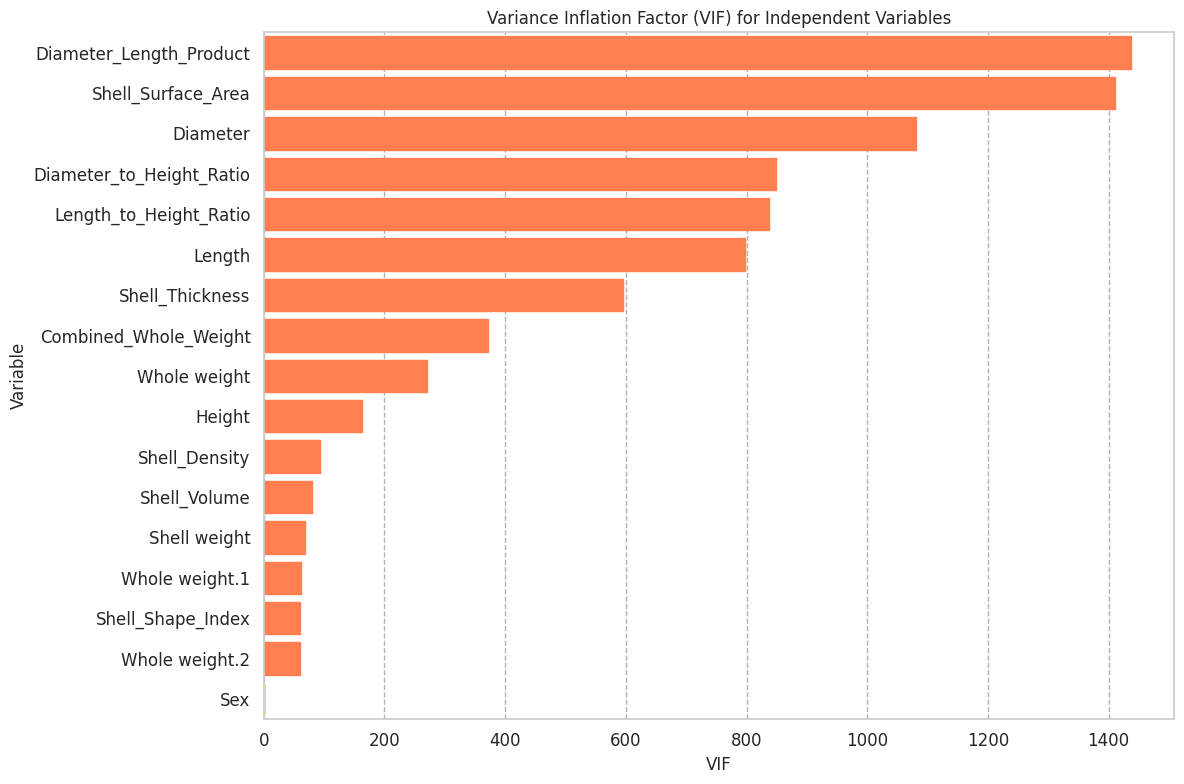

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort the dataframe by VIF values in descending order
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Set a VIF threshold (e.g., VIF > 5)
vif_threshold = 5

# Identify variables with high VIF that exceed the threshold
high_vif_variables = vif_data[vif_data["VIF"] > vif_threshold]

# Create a beautiful bar plot using Seaborn, highlighting high VIF variables
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plot = sns.barplot(x="VIF", y="Variable", data=vif_data, palette="viridis")

# Highlight high VIF variables
for bar in plot.patches:
    if bar.get_width() > vif_threshold:
        bar.set_color('coral')

plt.xlabel('VIF')
plt.ylabel('Variable')
plt.title('Variance Inflation Factor (VIF) for Independent Variables')
plt.xticks(fontsize=12)  # Increase font size of x-axis ticks
plt.yticks(fontsize=12)  # Increase font size of y-axis ticks
plt.grid(axis='x', linestyle='--', alpha=0.6, color='gray')  # Add grid lines
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

# 🔍🔍HYPOTHESIS TESTING🔍🔍

In [ ]:
target_columns = ['Rings']

# Perform pairwise t-tests for each target column with all other columns
significant_columns = {}
for target in target_columns:
    p_values = {}  # Initialize a dictionary for storing p-values for this target
    for column in df_train.columns:
        if column != target:  # Exclude the target column itself
            t_stat, p_value = ttest_ind(df_train[target], df_train[column])
            p_values[column] = p_value

    # Filter columns based on p-value threshold (e.g., 0.05)
    significant_columns[target] = [col for col, p_val in p_values.items() if p_val <= 0.05]

# Display the number of significant columns for each target column
for target, cols in significant_columns.items():
    print(f"Number of significant columns for '{target}': {len(cols)}")

Number of significant columns for 'Rings': 17


# Standardization

In [ ]:
df_train.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings', 'Diameter_to_Height_Ratio',
       'Combined_Whole_Weight', 'Diameter_Length_Product', 'Shell_Volume',
       'Shell_Surface_Area', 'Shell_Density', 'Shell_Thickness',
       'Shell_Shape_Index', 'Length_to_Height_Ratio'],
      dtype='object')

In [ ]:
X_scale = df_train.drop(columns='Rings', axis=1)
y_scale = df_train['Rings']

In [ ]:
ss = StandardScaler()
X_scale_S = ss.fit_transform(X_scale)

In [ ]:
X_scale_S

array([[-2.71139689e-02,  2.48916152e-01,  2.58151123e-01, ...,
        -1.81823943e-01, -4.70645765e-01, -5.59850889e-01],
       [-2.71139689e-02,  9.75497355e-01,  9.15856362e-01, ...,
        -1.25484078e+00, -3.51841226e-01,  1.27505542e+00],
       [ 1.16210786e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -6.12013841e-16,  0.00000000e+00],
       ...,
       [ 1.16210786e+00, -7.95544327e-01, -8.38024277e-01, ...,
         5.61033869e-01,  1.52401992e+00,  1.90851549e+00],
       [ 1.16210786e+00, -1.61294818e+00, -1.49572952e+00, ...,
         1.22135192e+00,  2.97468587e+00,  1.96547779e+00],
       [ 1.16210786e+00, -8.86366977e-01, -8.92833047e-01, ...,
         7.26113383e-01,  1.25202005e+00,  1.01847953e+00]])

# TRAIN - TEST - SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scale_S, y, test_size=0.2, random_state=42)

## Tạo DMatrix cho tập huấn luyện và tập validation

In [ ]:
X_trainXG, X_validXG, y_trainXG, y_validXG = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(X_trainXG, label=y_trainXG)
dvalid = xgb.DMatrix(X_validXG, label=y_validXG)

# ✨HYPERTUNING ✨ - tăng cường hiệu chỉnh

## XGBoost

In [ ]:
best_params = {
    'learning_rate': 0.02708319027879099,
    'n_estimators': 1000,                 # Sử dụng 'num_boost_round' là 'n_estimators' trong XGBRegressor
    'reg_alpha': 0.14219650343206225,
    'reg_lambda': 0.5045620145662986,
    'max_depth': 12,
    'subsample': 0.9537603851451735,
    'colsample_bytree': 0.7819555259366398,
    'min_child_weight': 1.03921704772634,
    'objective': 'reg:squarederror',  # Hàm mục tiêu cho bài toán hồi quy
    'eval_metric': 'rmse',
}

In [ ]:
evals = [(dtrain, 'train'), (dvalid, 'eval')]
model_XGB = xgb.XGBRegressor(**best_params)
model_XGB.fit(
    X_scale_S, y,
    eval_set=[(X_scale_S, y)],   # Tập dữ liệu để đánh giá, bạn có thể thay bằng tập 'valid' nếu có

    verbose=True
)


[0]	validation_0-rmse:2.23300
[1]	validation_0-rmse:2.19481
[2]	validation_0-rmse:2.15806
[3]	validation_0-rmse:2.12323
[4]	validation_0-rmse:2.08864
[5]	validation_0-rmse:2.05621
[6]	validation_0-rmse:2.02451
[7]	validation_0-rmse:1.99360
[8]	validation_0-rmse:1.96511
[9]	validation_0-rmse:1.93625
[10]	validation_0-rmse:1.90875
[11]	validation_0-rmse:1.88184
[12]	validation_0-rmse:1.85580
[13]	validation_0-rmse:1.83115
[14]	validation_0-rmse:1.80702
[15]	validation_0-rmse:1.78354
[16]	validation_0-rmse:1.76232
[17]	validation_0-rmse:1.74029
[18]	validation_0-rmse:1.71938
[19]	validation_0-rmse:1.69936
[20]	validation_0-rmse:1.67953
[21]	validation_0-rmse:1.66098
[22]	validation_0-rmse:1.64286
[23]	validation_0-rmse:1.62554
[24]	validation_0-rmse:1.60899
[25]	validation_0-rmse:1.59285
[26]	validation_0-rmse:1.57697
[27]	validation_0-rmse:1.56294
[28]	validation_0-rmse:1.54846
[29]	validation_0-rmse:1.53461
[30]	validation_0-rmse:1.52073
[31]	validation_0-rmse:1.50743
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7819555259366398, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02708319027879099,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=1.03921704772634, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Lấy RMSE tốt nhất trên tập validation
best_rmse = model.best_score
best_iteration = model.best_iteration

print(f"Best RMSE: {best_rmse} at iteration: {best_iteration}")

AttributeError: `best_score` is only defined when early stopping is used.

## CatBoostRegressor

In [ ]:
best_params_cat ={'learning_rate': 0.07855075323884125, 'n_estimators': 489, 'max_depth': 7,
                  'subsample': 0.8569934338945397, 'colsample_bylevel': 0.8150591618201379,
                  'reg_lambda': 0.4264547280178772}

In [ ]:
# model_cat = CatBoostRegressor(**best_params_cat)
# model_cat.fit(X_scale_S, y)

In [ ]:
# model_cat.best_score_

In [ ]:
# df_train.columns

In [ ]:
# features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
#        'Whole weight.2', 'Shell weight', 'is_child']
# label = 'Rings'
# df_train.info()
# feature_train = df_train[features]
# label_train = df_train[label]
# feature_test = df_test[features]

# Split X_train , y_train , X_test

In [ ]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X = feature_train.iloc[:,:].values
# y = label_train.values

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# scaler = StandardScaler()
# scaled_train_data = scaler.fit_transform(feature_train)
# scaled_test_data = scaler.transform(feature_test)


# n_splits = 3
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# xgb_predictions = np.zeros(len(scaled_train_data))
# xgb_true_labels = np.zeros(len(scaled_train_data))
# xgb_test_predictions = np.zeros(len(scaled_test_data))

# Training the XGBOOST

In [ ]:
'''
xgb_params={
     'colsample_bytree': 0.7,
     'subsample': 0.7,
     'learning_rate': 0.01,
     'max_depth': 10,
     'random_state': 2020,
     'min_child_weight': 5,
     'n_estimators': 10000,
     'early_stopping_rounds': 200,
     'tree_method': 'hist',
     'device': 'cuda',
}



for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, df_train[label])):
    print(f"Training fold {fold + 1}/{n_splits}...")

    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = df_train[label].iloc[train_idx], df_train[label].iloc[val_idx]

    # Convert data to DMatrix and explicitly specify the device
    dtrain = DMatrix(X_train, label=y_train)
    dval = DMatrix(X_val, label=y_val)
    dtest = DMatrix(scaled_test_data)

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits

    fold_rmse = np.sqrt(root_mean_squared_error(y_val, xgb_fold_preds))
    fold_r2 = r2_score(y_val, xgb_fold_preds)
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")
    print(f"Fold {fold + 1} R² Score: {fold_r2:.4f}")

    xgb_model.save_model(f"xgb_fold_{fold + 1}.json")

overall_rmse_xgb = np.sqrt(root_mean_squared_error(xgb_true_labels, xgb_predictions))
overall_r2_xgb = r2_score(xgb_true_labels, xgb_predictions)
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")
print(f"Overall R² Score (XGBRegressor): {overall_r2_xgb:.4f}")
'''

In [ ]:
# best_params_cat ={'learning_rate': 0.07855075323884125, 'n_estimators': 489, 'max_depth': 7,
#                   'subsample': 0.8569934338945397, 'colsample_bylevel': 0.8150591618201379,
#                   'reg_lambda': 0.4264547280178772}
# model_cat = CatBoostRegressor(**best_params_cat)
# model_cat.fit(X_train, y_train)
# y_pred = model_cat.predict(X_test)
# fold_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
# fold_r2 = r2_score(y_pred, y_test)
# print(f"RMSE: {fold_rmse:.4f}")
# print(f"R² Score: {fold_r2:.4f}")

In [ ]:
# best_params = {'learning_rate': 0.02708319027879099, 'n_estimators': 495, 'reg_alpha': 0.14219650343206225,
#                'reg_lambda': 0.5045620145662986, 'max_depth': 12, 'subsample': 0.9537603851451735,
#                'colsample_bytree': 0.7819555259366398, 'min_child_weight': 1.03921704772634}
# model = XGBRegressor(**best_params)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# fold_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
# fold_r2 = r2_score(y_pred, y_test)
# print(f"RMSE: {fold_rmse:.4f}")
# print(f"R² Score: {fold_r2:.4f}")